In [1]:
import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 
import matplotlib.pyplot as plt
import sys
import getopt

from datetime import  datetime

import fft8 as fft8 
import ld_utils as utils

import copy

pi = np.pi
tau = np.pi * 2

blocklenk = 16
blocklen = (blocklenk * 1024)

In [14]:
%matplotlib inline

In [2]:

# These are NTSC defaults.  They may be reprogrammed before starting
SysParams_NTSC = {
	'analog_audio': True,
	'audio_lfreq': 2301136,
	'audio_rfreq': 2812499,

	'fsc_mhz': (315.0 / 88.0),

	# video frequencies 
	'videorf_sync': 7600000,
	'videorf_0ire': 8100000,
	'videorf_100ire': 9300000, # slightly higher on later disks

	'ire_min': -60,
	'ire_max': 140,

	# changeable defaults
	#'deemp': (120, 320),
    'deemp': (135, 320),

	'vbpf': (3200000, 14000000),
    'vbpf_order': 1,
    
	'vlpf_freq': 4200000,	# in mhz
	'vlpf_order': 4		# butterworth filter order
}

SysParams_PAL = {
	'analog_audio': False, # not true for later PAL
	'audio_lfreq': 683593,
	'audio_rfreq': 1066400,

	'fsc_mhz': 4.43361875,

	# video frequencies 
	'videorf_sync': 6760000,
	'videorf_0ire': 7100000,
	'videorf_100ire': 8000000,

	'ire_min': -95, # needed for pilot signal
	'ire_max': 145,

	# changeable defaults
	'deemp': (50, 200),

	# XXX: guessing here!
	'vbpf': (2590000, 7900000),
    'vbpf_order': 1,
	'vlpf_freq': 5000000,	# in mhz
	'vlpf_order': 8		# butterworth filter order
}

# support reloading/rerunning from ipython
try:
    # a dummy load
	tmp = SysParams['fsc_mhz']
except:
	SysParams = copy.deepcopy(SysParams_PAL)
    

In [3]:
# Domesday Duplicator system uses 32mhz/10bit, expressed as 16-bit signed integers
CapParams_DomesdayDuplicator = {
    'freq': 32,
    'dtype': np.int16,
}

# cxadc can only really capture at 8fsc (28.8xmhz), with 8-bit unsigned samples
CapParams_cxadc = {
    'freq': (315.0 / 88.0) * 8.00,
    'dtype': np.uint8,
}

try:
    tmp = CapParams['freq']
except:
    CapParams = CapParams_cxadc

In [4]:
CapParams = CapParams_cxadc

SysParams = copy.deepcopy(SysParams_NTSC)

In [5]:
CapParams = CapParams_DomesdayDuplicator
SysParams = copy.deepcopy(SysParams_PAL)

In [50]:
SysParams['vsync_freq'] = 1000000
SysParams['vsync_order'] = 3

In [51]:
OverrideParams = {}

params = {}

for p in [SysParams, CapParams, OverrideParams]:
    for k in p.keys():
        print(k, p[k])
        params[k] = p[k]

analog_audio False
audio_lfreq 683593
audio_rfreq 1066400
fsc_mhz 4.43361875
videorf_sync 6760000
videorf_0ire 7100000
videorf_100ire 8000000
ire_min -95
ire_max 145
deemp (50, 200)
vbpf (2590000, 7900000)
vbpf_order 1
vlpf_freq 5000000
vlpf_order 8
vsync_freq 1000000
vsync_order 3
freq 32
dtype <class 'numpy.int16'>


In [52]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*200+[0]*200)
    #np.fft.ifft([0]+[1]*(blocklen//4)+[0]*(blocklen//4))
)
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

In [53]:
def filtfft(filt, blen = blocklen):
    return sps.freqz(filt[0], filt[1], blen, whole=1)[1]

def prepare_video_filters(SP):
    SP['freq_hz'] = SP['freq'] * 1000000
    
    freq_hz = SP['freq_hz']
    freq_hz_half = SP['freq_hz'] / 2
    
    # RF BPF and analog audio cut filters
    Fbpf = filtfft(sps.butter(SP['vbpf_order'], [SP['vbpf'][0]/freq_hz_half, SP['vbpf'][1]/freq_hz_half], btype='bandpass'))

    # standard post-demod LPF
    SP['plpf'] = filtfft(sps.butter(SP['vlpf_order'], SP['vlpf_freq']/freq_hz_half, 'low'))
    SP['psync'] = filtfft(sps.butter(SP['vsync_order'], SP['vsync_freq']/freq_hz_half, 'low'))

    # post-demod deemphasis filter
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10)/2.0, -SP['deemp'][0]*(10**-10)/2.0, SP['deemp'][0] / SP['deemp'][1])
    SP['deemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half))

    SP['fft_video'] = Fbpf * fft_hilbert

    if SP['analog_audio'] == True:
        Fcutl = filtfft(sps.butter(1, [(SP['audio_lfreq'] - 750000)/freq_hz_half, (SP['audio_lfreq'] + 750000)/(freq_hz/2)], btype='bandstop'))
        Fcutr = filtfft(sps.butter(1, [(SP['audio_rfreq'] - 750000)/freq_hz_half, (SP['audio_rfreq'] + 750000)/(freq_hz/2)], btype='bandstop'))

        # if AC3:
        #SP['f_arightcut'] = sps.butter(1, [(2650000)/(freq_hz/2), (3150000)/(freq_hz/2)], btype='bandstop')

        SP['fft_video'] *= (Fcutl * Fcutr)
        
    # Post processing:  lowpass filter + deemp
    SP['fft_post'] = SP['plpf'] * SP['deemp']

In [54]:
prepare_video_filters(params)

In [55]:
#infile = open('/home/cpage/ld-decode-samples/123017/JasonPAL_d4_tc1.raw_', 'rb')
infile = open('/home/cpage/ld-decode-samples/123017/Domesday_CommS_tc9.raw_', 'rb')

inbuf = infile.read(1024 * 1024)
inbuf = infile.read(1024 * 1024)

indata = np.fromstring(inbuf, 'int16', len(inbuf) // 2)

#indata = np.fromstring(inbuf, 'uint8', len(inbuf))

In [56]:
data = indata[0:blocklen]

In [131]:
import matplotlib
matplotlib.rc('figure', figsize=(20, 12))

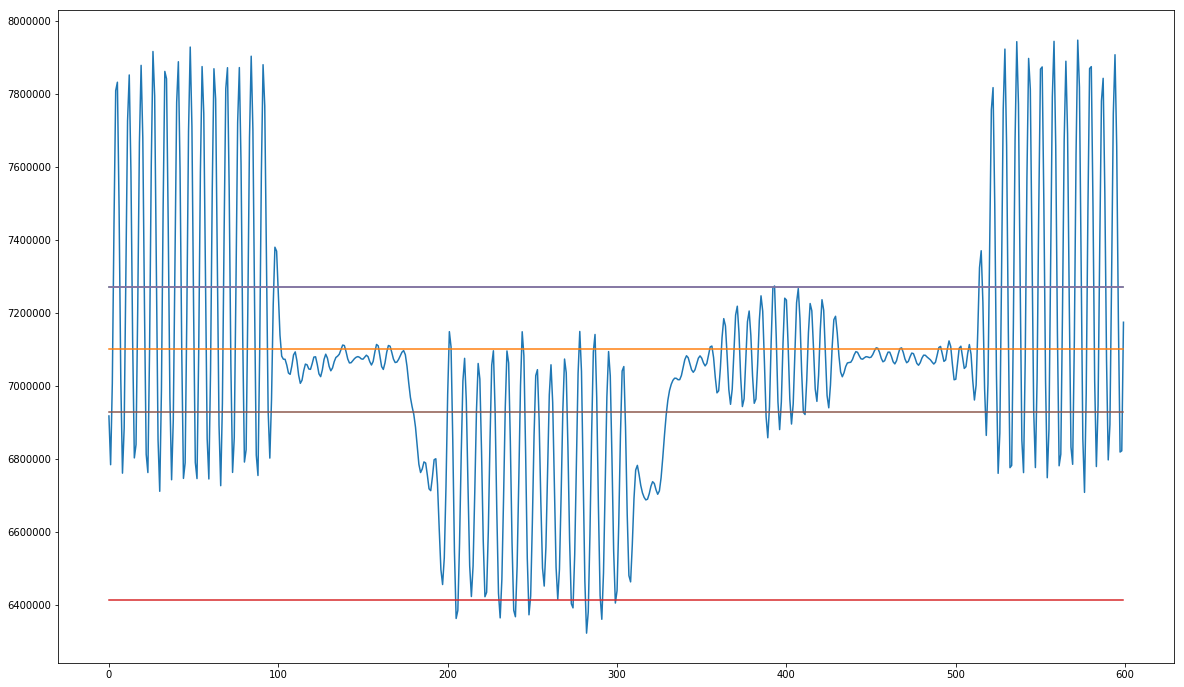

In [157]:
params['deemp'] = [100, 400]
params['vbpf'] = (2500000, 8100000)
params['vbpf_order'] = 2

params['vlpf_freq'] = 5500000
params['vlpf_order'] = 6

params['vsync_freq'] = 600000
params['vsync_order'] = 4

def dodemod(params, data):
    prepare_video_filters(params)

    data_fft = np.fft.fft(data)
    hilbert = np.fft.ifft(data_fft * params['fft_video'])

    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
            dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    demod = (tdangles2 * (params['freq_hz'] / tau))

    demod_fft = np.fft.fft(demod)

    output = np.fft.ifft(demod_fft * params['fft_post']).real
    #output_sync = np.fft.ifft(demod_fft * params['psync']).real
    
    return output

output = dodemod(copy.deepcopy(params), data)
outputp = output[2400:3000]
plt.plot(outputp)

'''
params['vbpf'] = (2500000, 7900000)
params['vbpf_order'] = 3

output = dodemod(copy.deepcopy(params), data)
outputp = output[2400:3000]
plt.plot(outputp)
'''
#plt.plot(output_sync[2400:3000])

plt.plot(np.full(len(outputp), 7100000))
plt.plot(np.full(len(outputp), 7100000 + (800000 * 1.5 / 7)))
plt.plot(np.full(len(outputp), (7900000-(800000/.7))-(800000*(3/7))))
plt.plot(np.full(len(outputp), 7100000 + (800000 * 1.5 / 7)))
plt.plot(np.full(len(outputp), 7100000 - (800000 * 1.5 / 7)))

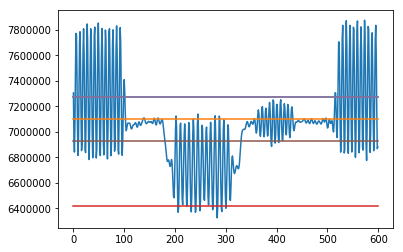

In [17]:
outputp = output2[2400:3000]
plt.plot(outputp)

plt.plot(np.full(len(outputp), 7100000))
plt.plot(np.full(len(outputp), 7100000 + (800000 * 1.5 / 7)))

plt.plot(np.full(len(outputp), (7900000-(800000/.7))-(800000*(3/7))))
plt.plot(np.full(len(outputp), 7100000 + (800000 * 1.5 / 7)))

plt.plot(np.full(len(outputp), 7100000 - (800000 * 1.5 / 7)))

In [828]:
900000*6/7

771428.5714285715

In [983]:
(7900000-(800000/.7))-(800000*(3/7))

6414285.714285715

In [831]:
6750000-(771428/2)

6364286.0

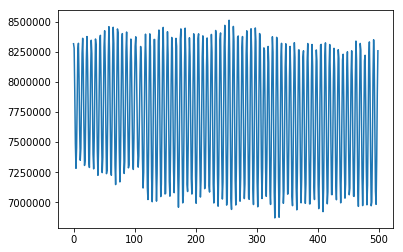

In [774]:
#plt.plot(output[1250:1700])
plt.plot(output[700:1200])

In [560]:
output_scaled = (output - 8100000) / (1700000 / 140)

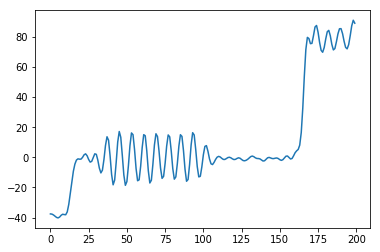

In [561]:
#plt.plot(output[1250:1700])
plt.plot(output_scaled[900:1100])

In [425]:
# Below this isn't right at all yet

In [34]:
t1 = 25
t2 = 13.75

[tf_b, tf_a] = sps.zpk2tf(-t2*(10**-8), -t1*(10**-8), t1 / t2)
Fmtf = filtfft(sps.bilinear(tf_b, tf_a, .5/params['freq_hz']))

In [35]:
Fmtf


array([ 1. +0.00000000e+00j,  1. +1.96105501e-05j,  1. +3.92211015e-05j,
       ...,  1. -5.88316557e-05j,  1. -3.92211015e-05j,
        1. -1.96105501e-05j])

In [103]:
freq = 32 * 1000 * 1000

In [104]:
def doplot(B, A):
        w, h = sps.freqz(B, A)

        fig = plt.figure()
        plt.title('Digital filter frequency response')
        
        db = 20 * np.log10(abs(h))
        for i in range(1, len(w)):
                if (db[i] >= -10) and (db[i - 1] < -10):
                        print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
                if (db[i] >= -3) and (db[i - 1] < -3):
                        print(">-3db crossing at ", w[i] * (freq/pi) / 2.0) 
                if (db[i] < -3) and (db[i - 1] >= -3):
                        print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 
                if (db[i] >= -1) and (db[i - 1] < -1):
                        print(">-1db crossing at ", w[i] * (freq/pi) / 2.0) 
                if (db[i] < -1) and (db[i - 1] >= -1):
                        print("<-1db crossing at ", w[i] * (freq/pi) / 2.0) 

        ax1 = fig.add_subplot(111)
        
        plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
        plt.ylabel('Amplitude [dB]', color='b')
        plt.xlabel('Frequency [rad/sample]')

        ax2 = ax1.twinx()
        angles = np.unwrap(np.angle(h))
        plt.plot(w * (freq/pi) / 2.0, angles, 'g')
        plt.ylabel('Angle (radians)', color='g')
        
        plt.grid()
        plt.axis('tight')
        plt.show()

In [1147]:
Fmtf.shape

(16384,)

In [1148]:
params

{'analog_audio': False,
 'audio_lfreq': 683593,
 'audio_rfreq': 1066400,
 'deemp': [100, 400],
 'dtype': numpy.int16,
 'fft_post': array([ 1.00000000+0.j        ,  0.99997648-0.00504917j,
         0.99990593-0.01009766j, ...,  0.99978837+0.01514482j,
         0.99990593+0.01009766j,  0.99997648+0.00504917j]),
 'fft_video': array([  0.00000000e+00 +0.00000000e+00j,
         -3.33629936e-13 -4.27120489e-12j,
         -1.09390257e-11 -6.95943584e-11j, ...,
          7.11802032e-11 -2.98800893e-10j,
          9.73203428e-12 -6.19154482e-11j,   3.14696585e-13 -4.02881591e-12j]),
 'fft_video_inner': array([  0.00000000e+00 +0.00000000e+00j,
         -3.30279762e-13 -4.27146981e-12j,
         -1.08298764e-11 -6.96117293e-11j, ...,
          7.04775327e-11 -2.98970420e-10j,
          9.63492823e-12 -6.19309024e-11j,   3.11536532e-13 -4.02906579e-12j]),
 'freq': 32,
 'freq_hz': 32000000,
 'fsc_mhz': 4.43361875,
 'ire_max': 145,
 'ire_min': -95,
 'output_minfreq': 1.2880529879718152,
 'output_sc

>-10db crossing at  1.90625
>-3db crossing at  2.40625
>-1db crossing at  2.71875
<-1db crossing at  7.28125
<-3db crossing at  7.90625


/home/cpage/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


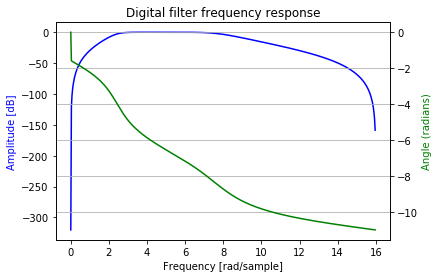

In [127]:
Fbpf = sps.butter(3, [2400000/16000000, 7900000/16000000], btype='bandpass')

doplot(Fbpf[0], Fbpf[1])

<-1db crossing at  0.75
<-3db crossing at  0.90625


/home/cpage/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


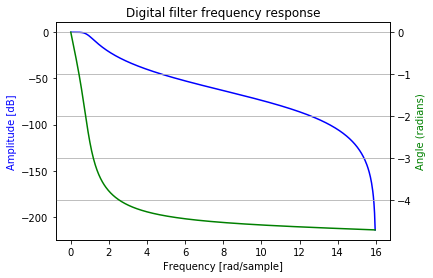

In [107]:
Fbpf = sps.butter(3, [900000/16000000], btype='lowpass')

doplot(Fbpf[0], Fbpf[1])

In [137]:
525*(30000/1001.0)

15734.265734265735

In [138]:
32000000/15734.265734

2033.777777812126

In [139]:

32.0/(315/88.0)

8.93968253968254

In [145]:
1.6/.6

2.666666666666667

In [146]:
3.2/1.2

2.666666666666667

In [147]:
2.35/.825

2.8484848484848486

In [148]:
1.2/2.848

0.4213483146067416

In [149]:

.6*2.848

1.7087999999999999

In [964]:
# PAL sync mid->edge
900000*1.5/7

192857.14285714287